In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers
from keras.layers import LSTM
from keras.regularizers import L1L2
import pandas as pd
import numpy as np


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,4)

Using TensorFlow backend.


In [2]:
raw = pd.read_csv('timeseires_example.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 16 columns):
DT                    371 non-null object
COMP_PRD_NO           371 non-null int64
COMP_STOCK_NO         371 non-null int64
BASE_QTY              371 non-null int64
INCM_QTY              371 non-null int64
END_QTY               371 non-null int64
ORD_CNT               371 non-null int64
ORD_QTY               371 non-null int64
MIN_ACTUAL_PAY        371 non-null int64
MED_ACTUAL_PAY        371 non-null int64
EVNT_11ST_2016        371 non-null object
EVNT_MW_HOT_ISSUE     371 non-null object
EVNT_MW_SHCK_DEAL     371 non-null object
EVNT_MW_LOWER_BANS    371 non-null object
EVNT_NOW_BANS         371 non-null object
EVNT_OTHERS           371 non-null object
dtypes: int64(9), object(7)
memory usage: 46.5+ KB


In [3]:
raw.head(2)

,DT,COMP_PRD_NO,COMP_STOCK_NO,BASE_QTY,INCM_QTY,END_QTY,ORD_CNT,ORD_QTY,MIN_ACTUAL_PAY,MED_ACTUAL_PAY,EVNT_11ST_2016,EVNT_MW_HOT_ISSUE,EVNT_MW_SHCK_DEAL,EVNT_MW_LOWER_BANS,EVNT_NOW_BANS,EVNT_OTHERS
0,2016-11-17,1624714294,6252686295,0,1024,1018,14,32,15840,17853,N,N,N,N,N,N
1,2016-11-18,1624714294,6252686295,1018,640,254,785,1592,12465,14685,N,N,Y,N,N,N


In [4]:
raw.tail(2)

,DT,COMP_PRD_NO,COMP_STOCK_NO,BASE_QTY,INCM_QTY,END_QTY,ORD_CNT,ORD_QTY,MIN_ACTUAL_PAY,MED_ACTUAL_PAY,EVNT_11ST_2016,EVNT_MW_HOT_ISSUE,EVNT_MW_SHCK_DEAL,EVNT_MW_LOWER_BANS,EVNT_NOW_BANS,EVNT_OTHERS
369,2017-11-23,1624714294,6252686295,1276,0,1154,97,127,15880,18400,N,N,N,N,N,N
370,2017-11-25,1624714294,6252686295,1688,0,1688,60,79,16710,18400,N,N,N,N,N,Y


In [5]:
dataset = raw.copy()
dataset.drop_duplicates(inplace=True)

In [6]:
target = dataset['ORD_QTY']
dataset['DT'] = pd.to_datetime(dataset['DT'])
dataset['week'] = dataset['DT'].dt.weekday_name
dataset['year'] = dataset['DT'].dt.year.apply(lambda x: 'year_'+str(x))
dataset['month'] = dataset['DT'].dt.month.apply(lambda x: 'month_'+str(x))
dataset['day'] = dataset['DT'].dt.day.apply(lambda x: 'day_'+str(x))
dataset.set_index('DT',inplace=True)
dataset.sort_index(inplace=True)

dataset.loc[:,'EVNT_11ST_2016'] = dataset['EVNT_11ST_2016'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_MW_HOT_ISSUE'] = dataset['EVNT_MW_HOT_ISSUE'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_MW_SHCK_DEAL'] = dataset['EVNT_MW_SHCK_DEAL'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_MW_LOWER_BANS'] = dataset['EVNT_MW_LOWER_BANS'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_NOW_BANS'] = dataset['EVNT_NOW_BANS'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_OTHERS'] = dataset['EVNT_OTHERS'].apply(lambda x: 1 if x=='Y'else 0)

dataset = pd.concat([dataset, pd.get_dummies(dataset['week'])],axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset['year'])],axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset['month'])],axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset['day'])],axis=1)
dataset['target'] = dataset['ORD_QTY']
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 2016-11-17 to 2017-11-27
Data columns (total 72 columns):
COMP_PRD_NO           371 non-null int64
COMP_STOCK_NO         371 non-null int64
BASE_QTY              371 non-null int64
INCM_QTY              371 non-null int64
END_QTY               371 non-null int64
ORD_CNT               371 non-null int64
ORD_QTY               371 non-null int64
MIN_ACTUAL_PAY        371 non-null int64
MED_ACTUAL_PAY        371 non-null int64
EVNT_11ST_2016        371 non-null int64
EVNT_MW_HOT_ISSUE     371 non-null int64
EVNT_MW_SHCK_DEAL     371 non-null int64
EVNT_MW_LOWER_BANS    371 non-null int64
EVNT_NOW_BANS         371 non-null int64
EVNT_OTHERS           371 non-null int64
week                  371 non-null object
year                  371 non-null object
month                 371 non-null object
day                   371 non-null object
Friday                371 non-null uint8
Monday                371 non-null uint8
Saturday   

In [7]:
dataset.drop(['COMP_PRD_NO','COMP_STOCK_NO','ORD_CNT','ORD_QTY','week','year','month','day'],axis=1,inplace=True)

In [8]:
target = ['target']

main_feature = dataset.drop(['MIN_ACTUAL_PAY', 'MED_ACTUAL_PAY', 'EVNT_11ST_2016',
       'EVNT_MW_HOT_ISSUE', 'EVNT_MW_SHCK_DEAL', 'EVNT_MW_LOWER_BANS',
       'EVNT_NOW_BANS', 'EVNT_OTHERS','target'],axis=1).columns.tolist()
aux_feature = dataset.columns.drop(target+main_feature)

In [9]:
aux_feature

Index(['MIN_ACTUAL_PAY', 'MED_ACTUAL_PAY', 'EVNT_11ST_2016',
       'EVNT_MW_HOT_ISSUE', 'EVNT_MW_SHCK_DEAL', 'EVNT_MW_LOWER_BANS',
       'EVNT_NOW_BANS', 'EVNT_OTHERS'],
      dtype='object')

In [10]:
data = dataset.copy()
in_seq = 14
out_seq = 14
batch_size = 10

In [11]:
feature_df = data[main_feature]
target_df = data[target]
aux_df = data[aux_feature]

feature_df = feature_df.astype('float32')
target_df = target_df.astype('float32')
aux_df = aux_df.astype('float32')

main_feature_len = len(main_feature)+len(target)

In [12]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0,1))
aux_scaler = MinMaxScaler(feature_range=(0,1))
    
feature_df.loc[:,:] = feature_scaler.fit_transform(feature_df)
target_df.loc[:,:] = target_scaler.fit_transform(target_df)
aux_df.loc[:,:] = aux_scaler.fit_transform(aux_df)

preprocessed_df = pd.concat([feature_df,target_df],axis=1)

In [13]:
preprocessed_df.head(2)

,BASE_QTY,INCM_QTY,END_QTY,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,target
DT,,,,,,,,,,,,,,,,,,,,,
2016-11-17,0.000000,0.32,0.146190,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019485
2016-11-18,0.147301,0.20,0.035497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [14]:
cols = list()
names = list()
for i in range(in_seq, 0, -1):
    cols.append(preprocessed_df.shift(i))
    names += [(feature_name+'(t-%d)' % i) for feature_name in preprocessed_df.columns]

In [15]:
temp_cols = list()
temp_names = list()
for i in range(out_seq):
    temp_cols.append(preprocessed_df[['target']].shift(-i))
    temp_names += [('t+%d' % i) for feature_name in preprocessed_df[['target']].columns]
    
aux_temp_cols = list()
aux_temp_names = list()
for i in range(out_seq):
    aux_temp_cols.append(aux_df.shift(-i))
    
    aux_temp_names += [feature_name+('(t+%d)' % i) for feature_name in aux_df.columns]

In [16]:
temp_df = pd.concat(temp_cols,axis=1)
temp_df.columns = temp_names
temp_df.dropna(inplace=True)

aux_temp_df = pd.concat(aux_temp_cols,axis=1)
aux_temp_df.columns = aux_temp_names
aux_df.dropna(inplace=True)

In [17]:
time_series_data = pd.concat(cols,axis=1)
time_series_data.columns = names
time_series_data.head(2)

,BASE_QTY(t-14),INCM_QTY(t-14),END_QTY(t-14),Friday(t-14),Monday(t-14),Saturday(t-14),Sunday(t-14),Thursday(t-14),Tuesday(t-14),Wednesday(t-14),...,day_3(t-1),day_30(t-1),day_31(t-1),day_4(t-1),day_5(t-1),day_6(t-1),day_7(t-1),day_8(t-1),day_9(t-1),target(t-1)
DT,,,,,,,,,,,,,,,,,,,,,
2016-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019485


In [18]:
time_series_data = pd.concat([time_series_data,temp_df],axis=1) 
time_series_data.dropna(inplace=True)
print(time_series_data.head(2))

            BASE_QTY(t-14)  INCM_QTY(t-14)  END_QTY(t-14)  Friday(t-14)  \
DT                                                                        
2016-12-05        0.000000            0.32       0.146190           0.0   
2016-12-06        0.147301            0.20       0.035497           1.0   

            Monday(t-14)  Saturday(t-14)  Sunday(t-14)  Thursday(t-14)  \
DT                                                                       
2016-12-05           0.0             0.0           0.0             1.0   
2016-12-06           0.0             0.0           0.0             0.0   

            Tuesday(t-14)  Wednesday(t-14)    ...          t+4       t+5  \
DT                                            ...                          
2016-12-05            0.0              0.0    ...     0.160277  0.135135   
2016-12-06            0.0              0.0    ...     0.135135  0.362665   

                 t+6       t+7       t+8       t+9      t+10      t+11  \
DT                     

In [19]:
time_series_data.index

DatetimeIndex(['2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14',
               ...
               '2017-11-04', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14'],
              dtype='datetime64[ns]', name='DT', length=344, freq=None)

In [20]:
train_size = int(len(time_series_data)/batch_size)*batch_size
test_size = batch_size*3

In [21]:
time_series_data = time_series_data.tail(train_size)

In [22]:
train_df = time_series_data.iloc[:-test_size]
test_df = time_series_data.iloc[-test_size:]

In [23]:
train_df.index

DatetimeIndex(['2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
               '2016-12-17', '2016-12-18',
               ...
               '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08',
               '2017-10-09', '2017-10-10', '2017-10-11', '2017-10-12',
               '2017-10-13', '2017-10-14'],
              dtype='datetime64[ns]', name='DT', length=310, freq=None)

In [24]:
test_df.index

DatetimeIndex(['2017-10-15', '2017-10-16', '2017-10-17', '2017-10-18',
               '2017-10-19', '2017-10-20', '2017-10-21', '2017-10-22',
               '2017-10-23', '2017-10-24', '2017-10-25', '2017-10-26',
               '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
               '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03',
               '2017-11-04', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14'],
              dtype='datetime64[ns]', name='DT', freq=None)

### aux_feature add

In [25]:
aux_df = pd.concat([aux_df,aux_temp_df],axis=1) 
aux_df.dropna(inplace=True)
print(aux_df.head(2))

            MIN_ACTUAL_PAY  MED_ACTUAL_PAY  EVNT_11ST_2016  EVNT_MW_HOT_ISSUE  \
DT                                                                              
2016-11-17        0.578578        0.533166             0.0                0.0   
2016-11-18        0.282265        0.002513             0.0                0.0   

            EVNT_MW_SHCK_DEAL  EVNT_MW_LOWER_BANS  EVNT_NOW_BANS  EVNT_OTHERS  \
DT                                                                              
2016-11-17                0.0                 0.0            0.0          0.0   
2016-11-18                1.0                 0.0            0.0          0.0   

            MIN_ACTUAL_PAY(t+0)  MED_ACTUAL_PAY(t+0)        ...          \
DT                                                          ...           
2016-11-17             0.578578             0.533166        ...           
2016-11-18             0.282265             0.002513        ...           

            EVNT_NOW_BANS(t+12)  EVNT_OTHERS(t+12

In [26]:
aux_df.index

DatetimeIndex(['2016-11-17', '2016-11-18', '2016-11-21', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30',
               ...
               '2017-11-04', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14'],
              dtype='datetime64[ns]', name='DT', length=358, freq=None)

In [27]:
aux_train_df = aux_df.loc[train_df.index]
aux_test_df = aux_df.loc[test_df.index]

In [28]:
aux_train_X = aux_train_df.values
aux_test_X = aux_test_df.values
print(aux_train_X.shape, aux_test_X.shape)

(310, 120) (30, 120)


In [29]:
train_X, train_y = train_df.values[:,:-out_seq], train_df.values[:,-out_seq:]
train_X, train_y = train_X.reshape(train_X.shape[0],in_seq,main_feature_len), train_y.reshape(train_y.shape[0],out_seq)

In [30]:
print(train_X.shape, train_y.shape)

(310, 14, 56) (310, 14)


In [31]:
test_X, test_y = test_df.values[:,:-out_seq], test_df.values[:,-out_seq:]
test_X, test_y = test_X.reshape(test_X.shape[0],in_seq,main_feature_len), test_y.reshape(test_y.shape[0],out_seq)

In [32]:
print(test_X.shape, test_y.shape)

(30, 14, 56) (30, 14)


In [33]:
import keras
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

In [34]:
main_input = Input(shape=(train_X.shape[1],train_X.shape[2]),batch_shape=(batch_size,train_X.shape[1],train_X.shape[2]),name='main_input')

x = LSTM(32,return_sequences=True,dropout=0.3,stateful=True)(main_input)
x = LSTM(32,dropout=0.4,stateful=True)(x)
lstm_out = x
#lstm_out = LSTM(32,dropout=0.3,stateful=True)(main_input)

auxiliary_output = Dense(out_seq,activation='sigmoid',name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(aux_train_X.shape[1],),batch_shape=(batch_size,aux_train_X.shape[1]),name='aux_input')

x = keras.layers.concatenate([lstm_out,auxiliary_input])
x = Dense(120,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)

main_output = Dense(out_seq,activation='sigmoid',name='main_output')(x)

model = Model(inputs=[main_input,auxiliary_input], outputs=[main_output,auxiliary_output])

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer='adam', loss='mse',loss_weights=[1.,0.4])

In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (10, 14, 56)          0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (10, 14, 32)          11392       main_input[0][0]                 
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (10, 32)              8320        lstm_1[0][0]                     
____________________________________________________________________________________________________
aux_input (InputLayer)           (10, 120)             0                                            
___________________________________________________________________________________________

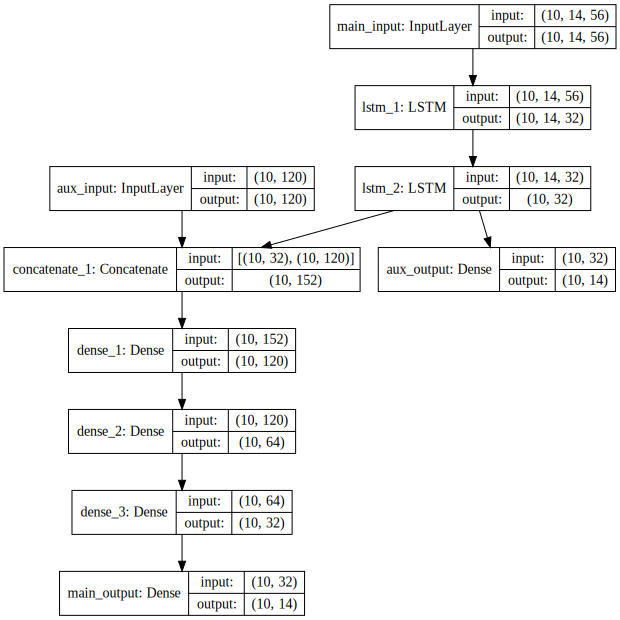

In [36]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [37]:
%%time
history = model.fit([train_X, aux_train_X], [train_y, train_y],epochs=50, batch_size=batch_size,\
                   validation_data=([test_X,aux_test_X],[test_y,test_y]),verbose=1,shuffle=False)

Train on 310 samples, validate on 30 samples
Epoch 1/50
310/310 [==============================] - 2s - loss: 0.1650 - main_output_loss: 0.1124 - aux_output_loss: 0.1315 - val_loss: 0.0691 - val_main_output_loss: 0.0462 - val_aux_output_loss: 0.0572
Epoch 2/50
310/310 [==============================] - 1s - loss: 0.0211 - main_output_loss: 0.0134 - aux_output_loss: 0.0193 - val_loss: 0.0151 - val_main_output_loss: 0.0113 - val_aux_output_loss: 0.0095
Epoch 3/50
310/310 [==============================] - 1s - loss: 0.0102 - main_output_loss: 0.0080 - aux_output_loss: 0.0054 - val_loss: 0.0136 - val_main_output_loss: 0.0102 - val_aux_output_loss: 0.0084
Epoch 4/50
310/310 [==============================] - 1s - loss: 0.0090 - main_output_loss: 0.0069 - aux_output_loss: 0.0052 - val_loss: 0.0130 - val_main_output_loss: 0.0096 - val_aux_output_loss: 0.0083
Epoch 5/50
310/310 [==============================] - 1s - loss: 0.0086 - main_output_loss: 0.0065 - aux_output_loss: 0.0051 - val_loss

310/310 [==============================] - 1s - loss: 0.0050 - main_output_loss: 0.0032 - aux_output_loss: 0.0045 - val_loss: 0.0121 - val_main_output_loss: 0.0083 - val_aux_output_loss: 0.0093
Epoch 41/50
310/310 [==============================] - 1s - loss: 0.0048 - main_output_loss: 0.0031 - aux_output_loss: 0.0044 - val_loss: 0.0126 - val_main_output_loss: 0.0088 - val_aux_output_loss: 0.0095
Epoch 42/50
310/310 [==============================] - 1s - loss: 0.0053 - main_output_loss: 0.0034 - aux_output_loss: 0.0045 - val_loss: 0.0126 - val_main_output_loss: 0.0088 - val_aux_output_loss: 0.0094
Epoch 43/50
310/310 [==============================] - 1s - loss: 0.0049 - main_output_loss: 0.0031 - aux_output_loss: 0.0045 - val_loss: 0.0130 - val_main_output_loss: 0.0093 - val_aux_output_loss: 0.0091
Epoch 44/50
310/310 [==============================] - 1s - loss: 0.0052 - main_output_loss: 0.0034 - aux_output_loss: 0.0046 - val_loss: 0.0121 - val_main_output_loss: 0.0085 - val_aux_ou

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


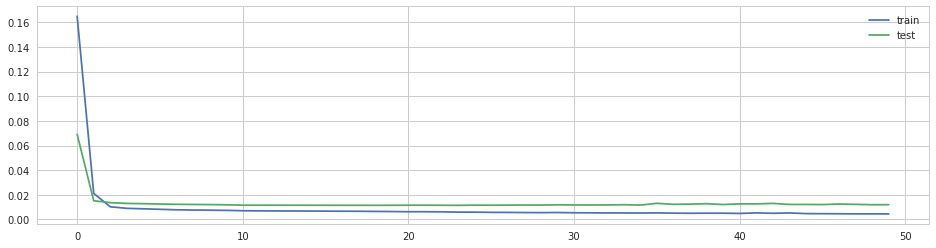

In [38]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
test_index = 0

In [40]:
main_result, aux_result = model.predict({'main_input':test_X[test_index:test_index+batch_size],\
                                         'aux_input':aux_test_X[test_index:test_index+batch_size]})

In [41]:
main_pred = pd.DataFrame(main_result,index=test_df.index[test_index:test_index+batch_size]).T
aux_pred = pd.DataFrame(aux_result,index=test_df.index[test_index:test_index+batch_size]).T

In [42]:
test_real = test_df.iloc[:,-out_seq:].copy()
test_real = test_real.T
test_real

DT,2017-10-15 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-21 00:00:00,2017-10-22 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00,...,2017-11-04 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,2017-11-11 00:00:00,2017-11-12 00:00:00,2017-11-13 00:00:00,2017-11-14 00:00:00
t+0,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,...,0.003771,0.031427,0.067882,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706
t+1,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,...,0.031427,0.067882,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909
t+2,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,...,0.067882,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424
t+3,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,...,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940
t+4,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,...,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941
t+5,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,...,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396
t+6,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,...,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681
t+7,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,0.101194,...,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681,0.049026
t+8,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,0.101194,0.125079,...,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681,0.049026,0.033941
t+9,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,0.101194,0.125079,0.126336,...,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681,0.049026,0.033941,0.079195


In [43]:
test_real.loc[:,:] = test_real.apply(target_scaler.inverse_transform)
main_pred.loc[:,:] = main_pred.apply(target_scaler.inverse_transform)
aux_pred.loc[:,:] = aux_pred.apply(target_scaler.inverse_transform)

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data ei

In [44]:
main_pred

DT,2017-10-15 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-21 00:00:00,2017-10-22 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00
0,155.772888,120.243042,69.771751,90.533409,122.148506,173.210190,137.779678,154.455338,168.335526,185.461349
1,150.442017,103.711769,126.018547,94.105133,140.847824,153.502136,110.298088,169.740921,184.658997,151.513290
2,91.302925,100.557701,139.241241,136.736633,154.322906,187.020493,188.409119,212.590164,125.593178,144.409668
3,70.345947,118.029716,122.087349,124.285660,137.961884,162.106522,191.858566,123.391441,115.283676,175.985626
4,90.360695,161.344894,160.116257,180.931778,223.459885,384.035370,302.914276,209.173141,193.672256,254.613663
5,105.266998,156.365875,280.731934,181.556122,293.233948,210.081741,206.019501,258.408783,156.061234,206.851730
6,122.204277,119.786728,142.267288,204.577042,92.014267,140.826279,245.014954,185.166641,176.570038,163.338242
7,97.313629,90.721382,129.794235,91.612831,103.600334,64.181908,71.983841,98.269547,87.914513,87.901604
8,74.803123,104.715202,144.995026,74.497536,158.950821,112.046051,78.219269,106.545677,107.869209,107.179375
9,251.401428,126.227737,120.633621,137.946426,127.196877,149.665451,132.283463,209.539001,199.637894,172.140625


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


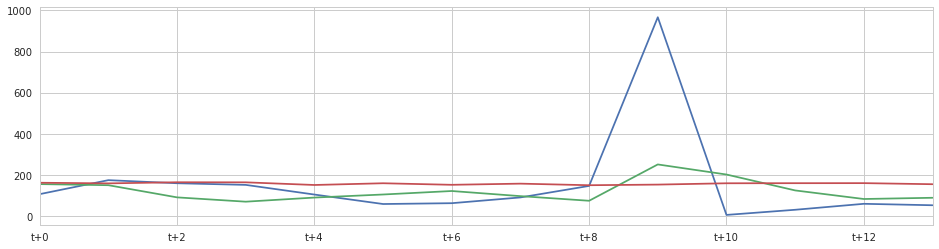

In [45]:
day = '2017-10-15 '
test_real[day].plot()
main_pred[day].plot()
aux_pred[day].plot()
# plt.plot(test_real.T)
# plt.plot(main_pred.T)
# plt.plot(aux_pred.T)

In [46]:
dataset.loc[day:].head(14).iloc[:,:11]

,BASE_QTY,INCM_QTY,END_QTY,MIN_ACTUAL_PAY,MED_ACTUAL_PAY,EVNT_11ST_2016,EVNT_MW_HOT_ISSUE,EVNT_MW_SHCK_DEAL,EVNT_MW_LOWER_BANS,EVNT_NOW_BANS,EVNT_OTHERS
DT,,,,,,,,,,,
2017-10-15,1489,0,1375,18140,18370,0,0,0,1,1,0
2017-10-16,1375,0,1211,17545,18370,0,0,0,1,1,0
2017-10-17,1211,0,1042,17545,18370,0,0,0,0,1,0
2017-10-18,1042,0,876,18140,18370,0,0,0,0,1,0
2017-10-19,876,0,757,18140,18370,0,0,0,0,1,0
2017-10-20,757,0,680,18140,18370,0,0,0,0,1,0
2017-10-21,680,0,680,18140,18370,0,0,0,0,1,0
2017-10-22,680,0,557,18140,18370,0,0,0,0,1,0
2017-10-23,557,640,1042,18140,18370,0,0,0,0,0,0


In [47]:
train_X.shape

(310, 14, 56)

In [48]:
aux_train_X.shape

(310, 120)

In [49]:
train_index = 20

In [50]:
train_main_result, train_aux_result = model.predict({'main_input':train_X[train_index:train_index+batch_size],\
                                                     'aux_input':aux_train_X[train_index:train_index+batch_size]})

In [51]:
train_main_pred = pd.DataFrame(train_main_result,index=train_df[train_index:train_index+batch_size].index).T
train_aux_pred = pd.DataFrame(train_aux_result,index=train_df[train_index:train_index+batch_size].index).T

In [52]:
train_real = train_df.iloc[:,-out_seq:].copy()
train_real = train_real.T
train_real

DT,2016-12-09 00:00:00,2016-12-10 00:00:00,2016-12-11 00:00:00,2016-12-12 00:00:00,2016-12-13 00:00:00,2016-12-14 00:00:00,2016-12-15 00:00:00,2016-12-16 00:00:00,2016-12-17 00:00:00,2016-12-18 00:00:00,...,2017-10-05 00:00:00,2017-10-06 00:00:00,2017-10-07 00:00:00,2017-10-08 00:00:00,2017-10-09 00:00:00,2017-10-10 00:00:00,2017-10-11 00:00:00,2017-10-12 00:00:00,2017-10-13 00:00:00,2017-10-14 00:00:00
t+0,0.160277,0.135135,0.362665,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,...,0.031427,0.077310,0.024513,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770
t+1,0.135135,0.362665,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,...,0.077310,0.024513,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625
t+2,0.362665,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,...,0.024513,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365
t+3,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,...,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937
t+4,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,...,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909
t+5,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,...,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368
t+6,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,...,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455
t+7,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,0.010685,...,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969
t+8,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,0.010685,0.016970,...,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568
t+9,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,0.010685,0.016970,0.015713,...,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766


In [53]:
train_real.loc[:,:] = train_real.apply(target_scaler.inverse_transform)
train_main_pred.loc[:,:] = train_main_pred.apply(target_scaler.inverse_transform)
train_aux_pred.loc[:,:] = train_aux_pred.apply(target_scaler.inverse_transform)

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data ei

In [54]:
index = 7

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


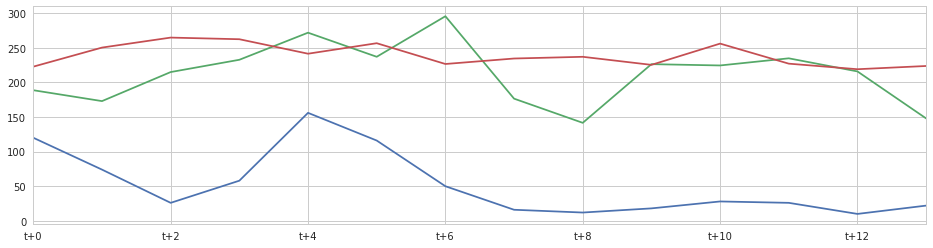

In [55]:
train_real.iloc[:,index].plot()
train_main_pred.iloc[:,index].plot()
train_aux_pred.iloc[:,index].plot()

# plt.plot(train_real.T)
# plt.plot(train_main_pred.T)
# plt.plot(train_aux_pred.T)

In [56]:
last_test = main_pred.T.tail(10)
last_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
DT,,,,,,,,,,,,,,
2017-10-15,155.772888,150.442017,91.302925,70.345947,90.360695,105.266998,122.204277,97.313629,74.803123,251.401428,202.380783,125.060799,83.375427,89.333496
2017-10-16,120.243042,103.711769,100.557701,118.029716,161.344894,156.365875,119.786728,90.721382,104.715202,126.227737,74.594734,82.709656,130.875977,69.934471
2017-10-17,69.771751,126.018547,139.241241,122.087349,160.116257,280.731934,142.267288,129.794235,144.995026,120.633621,115.036888,69.536392,190.078506,117.179558
2017-10-18,90.533409,94.105133,136.736633,124.285660,180.931778,181.556122,204.577042,91.612831,74.497536,137.946426,150.556931,119.919418,144.543365,74.688454
2017-10-19,122.148506,140.847824,154.322906,137.961884,223.459885,293.233948,92.014267,103.600334,158.950821,127.196877,105.234245,75.183479,118.167961,164.448761
2017-10-20,173.210190,153.502136,187.020493,162.106522,384.035370,210.081741,140.826279,64.181908,112.046051,149.665451,91.773567,129.791351,189.818237,133.512207
2017-10-21,137.779678,110.298088,188.409119,191.858566,302.914276,206.019501,245.014954,71.983841,78.219269,132.283463,126.786690,128.160416,183.874924,65.384697
2017-10-22,154.455338,169.740921,212.590164,123.391441,209.173141,258.408783,185.166641,98.269547,106.545677,209.539001,221.725601,115.419334,138.827133,109.032776
2017-10-23,168.335526,184.658997,125.593178,115.283676,193.672256,156.061234,176.570038,87.914513,107.869209,199.637894,149.054596,130.023300,158.373566,84.294685


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


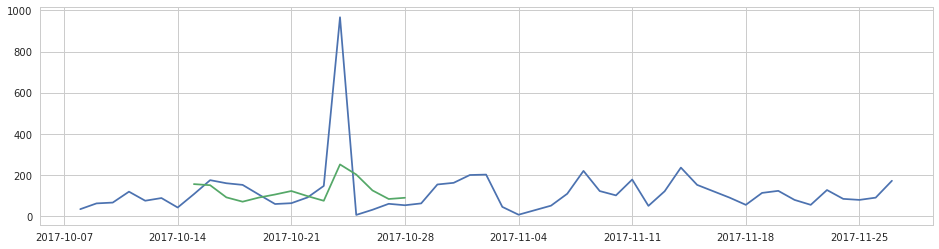

In [57]:
index = 10

last_test = main_pred.T.tail(index)
last_aux_test = aux_pred.T.tail(index)
last_test.columns = dataset.loc[last_test.index[0]:].head(14).index
last_aux_test.columns = dataset.loc[last_aux_test.index[0]:].head(14).index

plt.plot(dataset['target'].tail(50))
plt.plot(last_test.T.iloc[:,0])
#plt.plot(last_aux_test.T.iloc[:,0])

In [58]:
diff_value = pd.DataFrame(main_pred.values - test_real.values[:,:batch_size],columns=main_pred.columns)
diff_value

DT,2017-10-15 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-21 00:00:00,2017-10-22 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00
0,48.772894,-54.756960,-90.228252,-61.466592,17.148509,114.210187,74.779681,63.455335,21.335523,-781.538606
1,-24.557985,-56.288234,-25.981454,-10.894864,81.847822,90.502139,19.298085,22.740919,-782.340959,145.513291
2,-68.697078,-51.442300,34.241245,77.736631,91.322909,96.020490,41.409117,-754.409792,119.593178,113.409668
3,-81.654054,13.029720,63.087346,61.285662,46.961881,15.106520,-775.141389,117.391441,84.283676,115.985625
4,-14.639302,102.344892,97.116259,89.931775,76.459883,-582.964586,296.914276,178.173142,133.672255,201.613664
5,46.266996,93.365878,189.731931,34.556120,-673.766008,204.081741,175.019501,198.408782,103.061235,144.851732
6,59.204280,28.786725,-4.732714,-762.422914,86.014267,109.826279,185.014952,132.166643,114.570039,9.338243
7,6.313626,-56.278620,-837.205720,85.612831,72.600334,4.181906,18.983843,36.269548,-66.085486,-74.098397
8,-72.196879,-862.284753,138.995026,43.497536,98.950820,59.046053,16.219270,-47.454322,-54.130791,-92.820636
9,-715.598527,120.227738,89.633621,77.946425,74.196878,87.665452,-21.716536,47.539001,-0.362117,-29.859372


In [59]:
diff_value.apply(np.square).sum().apply(lambda x: x/out_seq).apply(np.sqrt)

DT
2017-10-15    204.737033
2017-10-16    238.852010
2017-10-17    240.349508
2017-10-18    213.833762
2017-10-19    192.089500
2017-10-20    178.312437
2017-10-21    234.487857
2017-10-22    225.047317
2017-10-23    226.287943
2017-10-24    233.033561
dtype: float64

In [60]:
sum_rmse = np.abs(test_real.sum() - main_pred.sum())
sum_rmse 

DT
2017-10-15    466.635699
2017-10-16    571.180992
2017-10-17    182.511433
2017-10-18    305.509356
2017-10-19    143.228237
2017-10-20     24.571568
2017-10-21     74.012414
2017-10-22    125.285435
2017-10-23    109.657312
2017-10-24      7.698451
2017-10-25           NaN
2017-10-26           NaN
2017-10-27           NaN
2017-10-28           NaN
2017-10-29           NaN
2017-10-30           NaN
2017-10-31           NaN
2017-11-01           NaN
2017-11-02           NaN
2017-11-03           NaN
2017-11-04           NaN
2017-11-06           NaN
2017-11-07           NaN
2017-11-08           NaN
2017-11-09           NaN
2017-11-10           NaN
2017-11-11           NaN
2017-11-12           NaN
2017-11-13           NaN
2017-11-14           NaN
dtype: float64